In [1]:
import copy
import ipywidgets
import json
import kaolin
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision

# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration
from gaussian_renderer import render
from scene.cameras import Camera as GSCamera

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/diff_gaussian_rasterization/build.ninja...
Building extension module diff_gaussian_rasterization...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module diff_gaussian_rasterization...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module diff_gaussian_rasterization, skipping build step...
Loading extension module diff_gaussian_rasterization...


ninja: no work to do.


In [2]:
from models.splatting.base_gaussian_model import BaseGaussianModel as GaussianModel

In [3]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians


def try_load_camera(model_path):
    """ Load one of the default cameras for the scene. """
    cam_path = os.path.join(model_path, 'cameras.json')
    if not os.path.exists(cam_path):
        print(f'Could not find saved cameras for the scene at {camp_path}; using default for ficus.')
        return GSCamera(colmap_id=0,
                        R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]), 
                        T=np.array([6.8159e-09, 2.0721e-10, 4.03112e+00]), 
                        FoVx=0.69111120, FoVy=0.69111120, 
                        image=torch.zeros((3, 800, 800)),  # fake 
                        gt_alpha_mask=None, image_name='fake', uid=0)
        
    with open(cam_path) as f:
        data = json.load(f)
        raw_camera = data[0]
        
    tmp = np.zeros((4, 4))
    tmp[:3, :3] = raw_camera['rotation']
    tmp[:3, 3] = raw_camera['position']
    tmp[3, 3] = 1
    C2W = np.linalg.inv(tmp)
    R = C2W[:3, :3].transpose()
    T = C2W[:3, 3]
    width = raw_camera['width']
    height = raw_camera['height']
    fovx = focal2fov(raw_camera['fx'], width)
    fovy = focal2fov(raw_camera['fy'], height)
    return GSCamera(colmap_id=0,
                    R=R, T=T, FoVx=fovx, FoVy=fovy, 
                    image=torch.zeros((3, height, width)),  # fake 
                    gt_alpha_mask=None, image_name='fake', uid=0)


model_path = 'output/base_model'
gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
test_camera = try_load_camera(model_path)

render: [3, 1090, 1959] (torch.float32)[cuda:0]  - [min 0.0002, max 1.2394, mean 0.4050] 
gaussian_alphas: [832975, 1] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
viewspace_points: [832975, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
visibility_filter: [832975] (torch.bool)[cuda:0]  - [min 0.0000, max 1.0000, mean 0.7419] 
radii: [832975] (torch.int32)[cuda:0]  - [min 0.0000, max 19583.0000, mean 8.8047] 


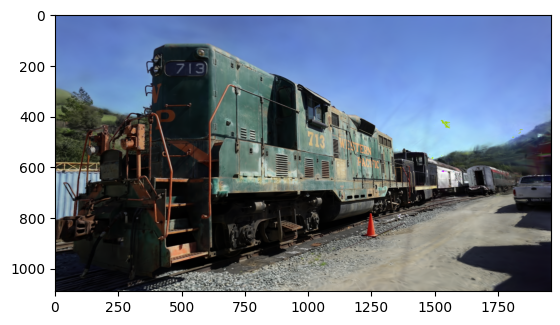

In [4]:
render_res = render(test_camera, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

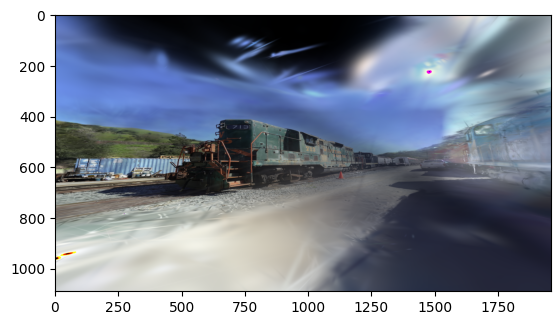

In [7]:
def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

def convert_kaolin_camera(kal_camera):
    """ Convert kaolin camera to GS camera. """
    R = kal_camera.extrinsics.R[0]
    R[1:3] = -R[1:3]
    T = kal_camera.extrinsics.t.squeeze()
    T[1:3] = -T[1:3]
    return GSCamera(colmap_id=0,
                    R=R.transpose(1, 0).cpu().numpy(), 
                    T=T.cpu().numpy(), 
                    FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                    FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                    image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                    gt_alpha_mask=None,
                    image_name='fake',
                    uid=0)

def convert_gs_camera(gs_camera):
    """ Convert GS camera to Kaolin camera. """
    view_mat = gs_camera.world_view_transform.transpose(1, 0)
    view_mat[1:3] = -view_mat[1:3]
    res = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=gs_camera.image_width, height=gs_camera.image_height,
        fov=gs_camera.FoVx, device='cpu')
    return res

# Test that we can render the same thing
kal_cam = convert_gs_camera(test_camera)
test_cam_back = convert_kaolin_camera(kal_cam)
rendering = render(test_cam_back, gaussians, pipeline, background)["render"]
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

In [ ]:
def render_kaolin(kaolin_cam):
    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

focus_at = (kal_cam.cam_pos() - 4. * kal_cam.extrinsics.cam_forward()).squeeze()
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=30)
visualizer.show()

In [ ]:
log_tensor(gaussians.get_scaling, 'scaling after activation', print_stats=True)
log_tensor(gaussians._scaling, 'scaling, raw', print_stats=True)

def selective_render_kaolin(kaolin_cam):
    """Same rendering as above, but we subsample gaussians based on their scale."""
    # Select only the gaussians with radius below value
    scaling = gaussians._scaling.max(dim=1)[0]
    mask = scaling < slider.value
    tmp_gaussians = GaussianModel(gaussians.max_sh_degree)
    tmp_gaussians._xyz = gaussians._xyz[mask, :]
    tmp_gaussians._features_dc = gaussians._features_dc[mask, ...]
    tmp_gaussians._features_rest = gaussians._features_rest[mask, ...]
    tmp_gaussians._opacity = gaussians._opacity[mask, ...]
    tmp_gaussians._scaling = gaussians._scaling[mask, ...]
    tmp_gaussians._rotation = gaussians._rotation[mask, ...]
    tmp_gaussians.active_sh_degree = gaussians.max_sh_degree

    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, tmp_gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

def handle_slider(e):
    visualizer.out.clear_output()
    with visualizer.out:
        visualizer.render_update()

# Instantiate visualizer with this custom render function
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), selective_render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=30)

# Instantiate slider to control scaling
scaling = gaussians._scaling.max(dim=1)[0]
slider = ipywidgets.FloatSlider(value=scaling.max().item(),
    min=scaling.min().item(), max=scaling.max().item(),
    step=0.1,
    description='Max scale:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
slider.observe(handle_slider, names='value')

visualizer.render_update()
display(visualizer.canvas, visualizer.out, slider)